In [1]:
#%pip install torch
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 100 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 100
n_embd = 512
n_head = 6
n_layer = 9
dropout = 0.2


cuda


In [2]:
import os
def save(model,file_name='modelDistribution1.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(),file_name)
    
def load(file_name='modelDistribution1.pth'):
    model_folder_path = './model'
    
    file_name = os.path.join(model_folder_path, file_name)
    return file_name
    #torch.save(self.state_dict(),file_name)
    


In [3]:
torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('inputAnime.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()
#Alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890?!()\n "
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
Alphabet = chars
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


print(len(train_data))

4022676


In [4]:
train_data.shape

torch.Size([4022676])

In [5]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    #print(x,len(y))
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        #print(B,T)

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            #print(idx,"DIFF",idx_cond)
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1]#, :] # becomes (B, C)
            
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx




In [6]:
model = GPTLanguageModel()
model.load_state_dict(torch.load('./model/modelDistribution1.pth'))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

28.456017 M parameters


In [7]:
torch.cuda.is_available()

True

In [8]:
for iter in range(max_iters):
   
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        save(model)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.9714, val loss 1.0163
step 50: train loss 0.9764, val loss 1.0168
step 100: train loss 0.9710, val loss 1.0160
step 150: train loss 0.9679, val loss 1.0154
step 200: train loss 0.9677, val loss 1.0113
step 250: train loss 0.9661, val loss 1.0110
step 300: train loss 0.9630, val loss 1.0107
step 350: train loss 0.9545, val loss 1.0069
step 400: train loss 0.9594, val loss 1.0020
step 450: train loss 0.9558, val loss 1.0009


KeyboardInterrupt: 

In [27]:

# import modules
import pandas as pd
 
# read the data from the csv
device = 'cpu'
alphabet = Alphabet

f = open("inputAnime.txt", "r", errors="ignore", encoding="utf-8")
inputText = "The big wolf walked away because he was bad nothing"
multiplier = 50
f.close()
chars = sorted(list(set(alphabet)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ''.join([itosT[i] for i in l])
outputArr = []
for i in range(0,10):
    dataT = torch.tensor(encoder(inputText.split(" ")[i]), dtype=torch.long,device='cpu')
    dataT = dataT.detach().numpy()

    print(list(dataT))
    temp = []
    for i in range(0,len(list(dataT))):
        temp.append(dataT[i])
    print(temp)
    dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
    print(dataT)
    context = dataT.to(device)#torch.tensor(dataInput)

    output = (decode(model.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*multiplier)[0].tolist()))
    outputArr.append(output)

[31, 45, 42]
[31, 45, 42]
tensor([31, 45, 42])
[39, 46, 44]
[39, 46, 44]
tensor([39, 46, 44])
[60, 52, 49, 43]
[60, 52, 49, 43]
tensor([60, 52, 49, 43])
[60, 38, 49, 48, 42, 41]
[60, 38, 49, 48, 42, 41]
tensor([60, 38, 49, 48, 42, 41])
[38, 60, 38, 62]
[38, 60, 38, 62]
tensor([38, 60, 38, 62])
[39, 42, 40, 38, 58, 56, 42]
[39, 42, 40, 38, 58, 56, 42]
tensor([39, 42, 40, 38, 58, 56, 42])
[45, 42]
[45, 42]
tensor([45, 42])
[60, 38, 56]
[60, 38, 56]
tensor([60, 38, 56])
[39, 38, 41]
[39, 38, 41]
tensor([39, 38, 41])
[51, 52, 57, 45, 46, 51, 44]
[51, 52, 57, 45, 46, 51, 44]
tensor([51, 52, 57, 45, 46, 51, 44])


In [28]:
#Give 10 contexts and generate 20x of each context 
#This hopefully will change the distribution
#DONT INCLUDE CONTEXTS it might skew data

finalArr = []
for i in outputArr:
    finalArr.append(' '.join(i.split(" ")[1:]))
print(finalArr)

['situdent confience  \nSakura\nAhh \n Action  Mikoshiba falls down all as Nozaki studying some coats when he gets through the abpult  \nNozaki\nWwe were ritters or treation president  I just started into school explories \n Scene  At the negy end “middle  Satsuki Gang Schocolare” \nSatsuki\nOkano \nTatsumi\nErk \n Thoughts  I wanted to it  When would tray \nMisaki\nErk \n Action  Usui and talk through down the notebooks  \nCustomer 1\nWe… wantted to begin with this cheap toward Grant’s formers  Misa chan \nMinori\n Thoughts  About her first female from the cafe here being herself  and Hail’s heavother  \nNagisa\nWhy so you look at paces  Nagara \n Action  As Hanazomi sundredles bushes at the 3 Idorite  \nShallway Tamaki\n Flashback  How long kids that Tamaki… A good was that collections would have to keep losical ors work and pulling from together  \nHayakawa\nHow wabdoring you to school \nAh…\n Thoughts  Stop like  replying populars \n Narration  There are in Violet Company trains am

In [29]:
print(output)

nothing ”
 Action  Minori’s stuff onter tee Gin  
Besides  They’s…
Kitamura
Ahh…
 Action  Kitamura pulls his knees and plice to Yukimura Twins
Huh 
Misui
Is that so fast that for me…
 Action  Usui points to Misaki at  bobby  in high pharses shoulders  
Misaki
 Thoughts  Damn it  
Boys
Ahhh  That’s what thinking is sulking about things of punch and his cliff… 
Namahagara  A boy ever…
 Action  Nozaki and Get into a four story at Nozaki  
Sakura
Whoho’s this he  Where are you  
Sakura
Nozaki’s visity 
 Action  Nozaki adj three soldiers complete… on Nozaki’s changing  
Nozaki
Ah Ayuzawa Akari 
Namako
Okay 
Atsushi
Hori senpai  you know 
Nozaki  A sun  you’re just Hori 
Honey
Oh  I’ll blow us 
Yukimura  Yukimura
Ngh… 
Sakura
Ugh… 
Yukimura
Yukimura’s KaYu Group 
Usui
Oh  
You got sure to your side 
 Action  Usui runs out of her hangivisite  
Misaki
Ahh  Fore talks to say she  that’s awkward 
Satsuki
Good like my nervous miscooching for the Host Club 
Sakura
You know  but if just concerned a

In [30]:
animeDict = {}
with open ("inputAnime.txt", "r", encoding="utf8") as myfile:
    data = myfile.read().replace("\n", '')
    print(data)
    freq = 0
    for char in data:
        if char in animeDict:
            animeDict[char] += 1
        else:
            animeDict.update({char:1})
    print(freq)

Dazai Narration  Stray dogs  Narration  A pack of lost dogs dashing aimlessly through the abyss of Yokohama  Scene  Dog Atsushi  runs through the streets  D AtsushiSomething terrible is happening I have to tell Dazai and the others  Scene  Elsewhere on the streets  Dog Dazai looks at a bar of chocolate  D DazaiHmm… I could die if I ate this But I don’t want to suffer D AtsushiQuick  Dazai san  Kunikida san  Action  Dog Kunikida appears from a pile of pipes without his glasses  D KunikidaMmh… My glasses… my glasses  Action  Kunikida puts on his glasses  D KunikidaWhat is it  Atsushi D AtsushiOur turf is being invaded D DazaiSay what D AtsushiThe scent in front of that building has changed D KunikidaThat building  huh That building used to be among our favorites D DazaiIt’s a precious feeding ground for lost dogs such as us D AtsushiYes…D DazaiWe absolutely cannot allow it to be taken by other dogs D AtsushiLet’s go quickly D Dazai  D KunikidaOkay  Scene  At the front of the building  At

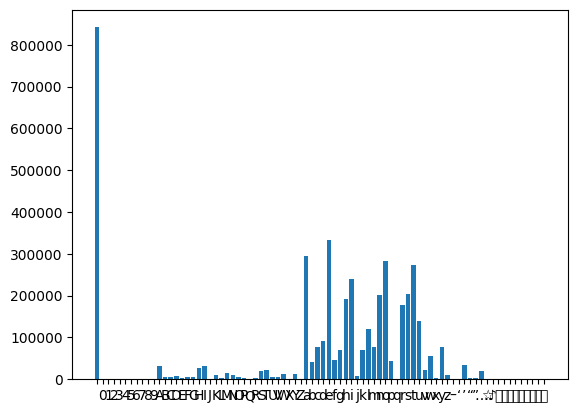

In [31]:
import matplotlib.pyplot as plt

D = {key: value for key, value in sorted(animeDict.items())}

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
#plt.yticks(range(len(D)),3500)
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

situdent confience  SakuraAhh  Action  Mikoshiba falls down all as Nozaki studying some coats when he gets through the abpult  NozakiWwe were ritters or treation president  I just started into school explories  Scene  At the negy end “middle  Satsuki Gang Schocolare” SatsukiOkano TatsumiErk  Thoughts  I wanted to it  When would tray MisakiErk  Action  Usui and talk through down the notebooks  Customer 1We… wantted to begin with this cheap toward Grant’s formers  Misa chan Minori Thoughts  About her first female from the cafe here being herself  and Hail’s heavother  NagisaWhy so you look at paces  Nagara  Action  As Hanazomi sundredles bushes at the 3 Idorite  Shallway Tamaki Flashback  How long kids that Tamaki… A good was that collections would have to keep losical ors work and pulling from together  HayakawaHow wabdoring you to school Ah… Thoughts  Stop like  replying populars  Narration  There are in Violet Company trains among the party  Narration  That’s what I’s tashing right no

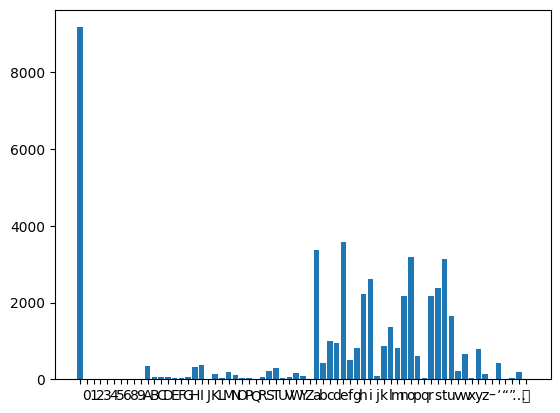

In [32]:
import matplotlib.pyplot as plt
animeOutputDict = {}
output = ' '.join(finalArr)
data = output.replace("\n", '')
print(data)
freq = 0
for char in range(0,len(data)):
    if data[char] in animeOutputDict:
        animeOutputDict[data[char]] += 1
    else:
        animeOutputDict.update({data[char]:1})
print(freq)
D = {key: value for key, value in sorted(animeOutputDict.items())}
#D = 

plt.bar(range(len(D)), list(D.values()), align='center',label = "Generated")
B = {key: value for key, value in sorted(animeDict.items())}

#plt.bar(range(len(B)), list(B.values()), align='center',label = "Dataset")
#plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(range(len(D)), list(D.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()